<a href="https://colab.research.google.com/github/Asiya-Arif/DS_Asiya-Arif/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import os
sns.set(style="whitegrid")

# Load Datasets

In [107]:
btc_sentiment_path = '/content/fear_greed_index.csv'
trader_data_path = '/content/historical_data.csv'

In [108]:
btc_sentiment = pd.read_csv(btc_sentiment_path)
trader_data = pd.read_csv(trader_data_path)

# Convert Date Columns

In [105]:
btc_sentiment['date'] = pd.to_datetime(btc_sentiment['date'], errors='coerce')
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], errors='coerce', format='%d-%m-%Y %H:%M')

# Missing Value Checks

In [128]:
print("Missing values in Bitcoin Sentiment Dataset:")
print(btc_sentiment.isnull().sum())
print("\nMissing values in Trader Data:")
print(trader_data.isnull().sum())

Missing values in Bitcoin Sentiment Dataset:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values in Trader Data:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


# Basic Data Info & Stats

In [7]:
# Preview data samples
print("Bitcoin Sentiment Dataset Sample:")
print(btc_sentiment.head())
print("\nTrader Data Sample:")
print(trader_data.head())

Bitcoin Sentiment Dataset Sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trader Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       

In [124]:
print("Unique Traders:", trader_data['Account'].nunique())
print("Unique Symbols Traded:", trader_data['Coin'].nunique())
print("Date range in Sentiment Data:", btc_sentiment['date'].min(), "to", btc_sentiment['date'].max())
print("Date range in Trader Data:", trader_data['Timestamp IST'].min(), "to", trader_data['Timestamp IST'].max())

Unique Traders: 32
Unique Symbols Traded: 246
Date range in Sentiment Data: 2018-02-01 to 2025-05-02
Date range in Trader Data: 01-01-2024 01:23 to 31-12-2024 23:33


In [123]:
print("Closed PnL Statistics:")
print(trader_data['Closed PnL'].describe())


Closed PnL Statistics:
count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: Closed PnL, dtype: float64


# Data Aggregation and Merging

In [9]:
# Convert 'Date' and 'time' columns to datetime
btc_sentiment['date'] = pd.to_datetime(btc_sentiment['date'], errors='coerce')
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], errors='coerce', format='%d-%m-%Y %H:%M')

In [68]:
# Extract date from trader_data datetime
trader_data['Date'] = trader_data['Timestamp IST'].dt.date

In [28]:
# Aggregate trader data by date
daily_trader_metrics = trader_data.groupby('Date').agg(
    total_trades=('Account', 'count'),
    unique_traders=('Account', 'nunique'),
    avg_closedPnL=('Closed PnL', 'mean'),
    total_volume=('Size USD', 'sum')
).reset_index()

# Convert the 'Date' column to datetime objects after aggregation
daily_trader_metrics['Date'] = pd.to_datetime(daily_trader_metrics['Date'])

In [30]:
# Merge aggregated trader data with sentiment data
merged_data = pd.merge(daily_trader_metrics, btc_sentiment, left_on='Date', right_on='date', how='inner')

In [33]:
# Check for missing values in the merged dataframe
print("\nMissing values in Merged Data:")
print(merged_data.isnull().sum())


Missing values in Merged Data:
Date              0
total_trades      0
unique_traders    0
avg_closedPnL     0
total_volume      0
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [32]:
# Display the first few rows of the merged dataframe
print("Merged Data Sample:")
display(merged_data.head())

Merged Data Sample:


Date  total_trades  unique_traders  avg_closedPnL  total_volume  \
0 2024-03-13             7               1       0.000000       6000.80   
1 2024-03-14             1               1      65.480454       6066.28   
2 2024-03-15             8               1      42.303540      26339.81   
3 2024-03-16             6               1      38.096640      27223.66   
4 2024-03-17            14               1      30.691648      87063.35   

    timestamp  value classification       date  
0  1710307800     81  Extreme Greed 2024-03-13  
1  1710394200     88  Extreme Greed 2024-03-14  
2  1710480600     83  Extreme Greed 2024-03-15  
3  1710567000     81  Extreme Greed 2024-03-16  
4  1710653400     79  Extreme Greed 2024-03-17

# Analysis and Visualization

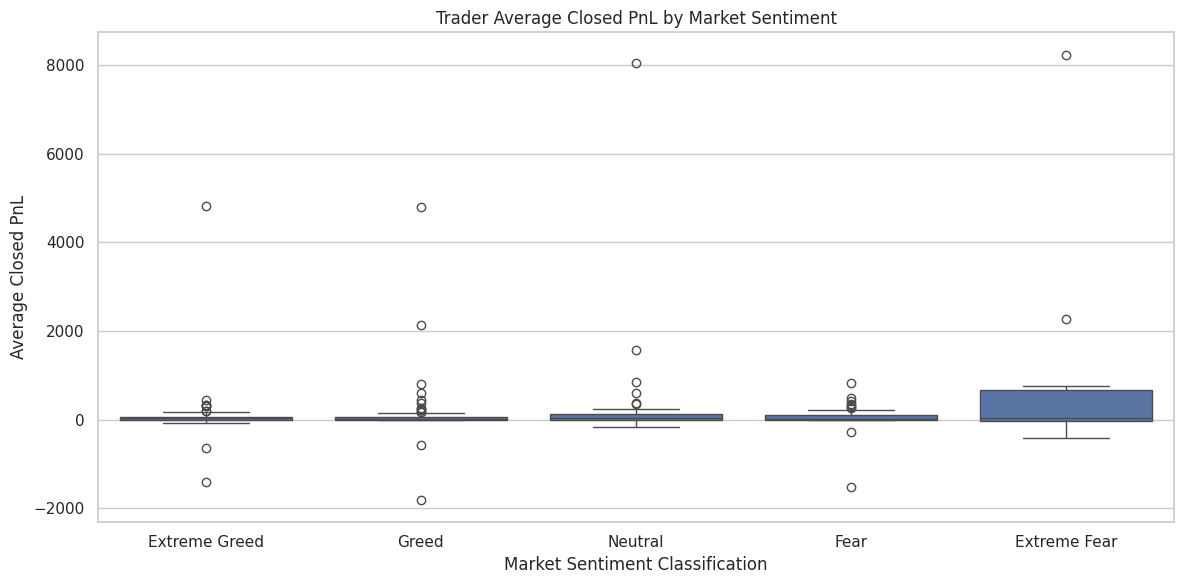

In [135]:
# Visualization of avg_closedPnL for Fear vs Greed days
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_data, x='classification', y='avg_closedPnL')
plt.title('Trader Average Closed PnL by Market Sentiment')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Average Closed PnL')
plt.tight_layout()
plt.show()

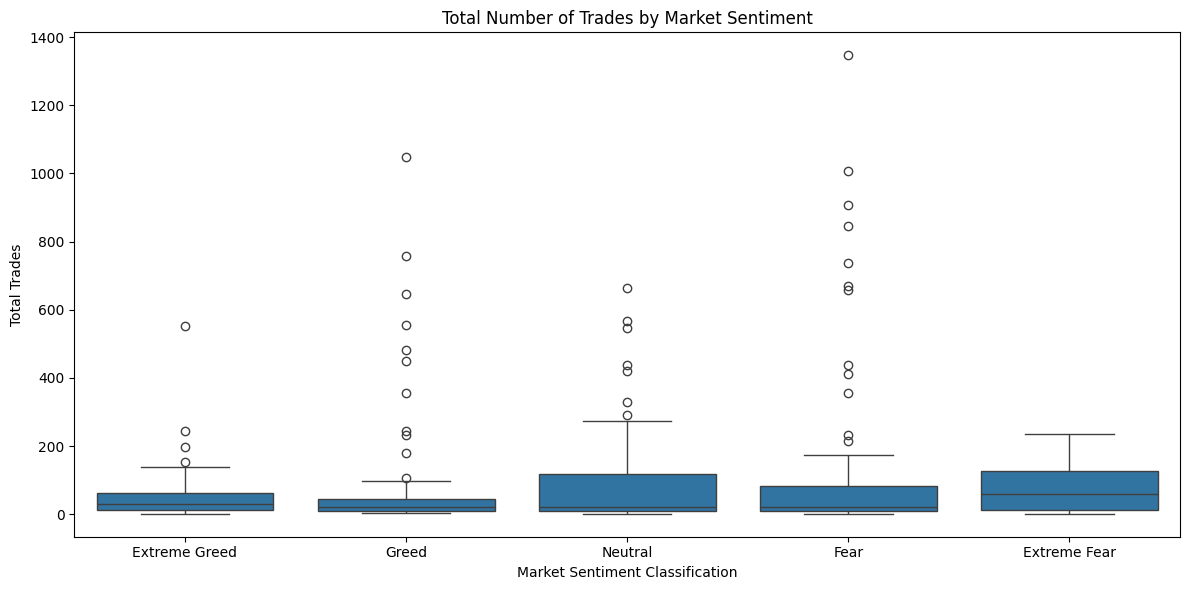

In [92]:
# Visualization of Total Trades by Sentiment Classification
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_data, x='classification', y='total_trades')
plt.title('Total Number of Trades by Market Sentiment')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Total Trades')
plt.tight_layout()
plt.show()

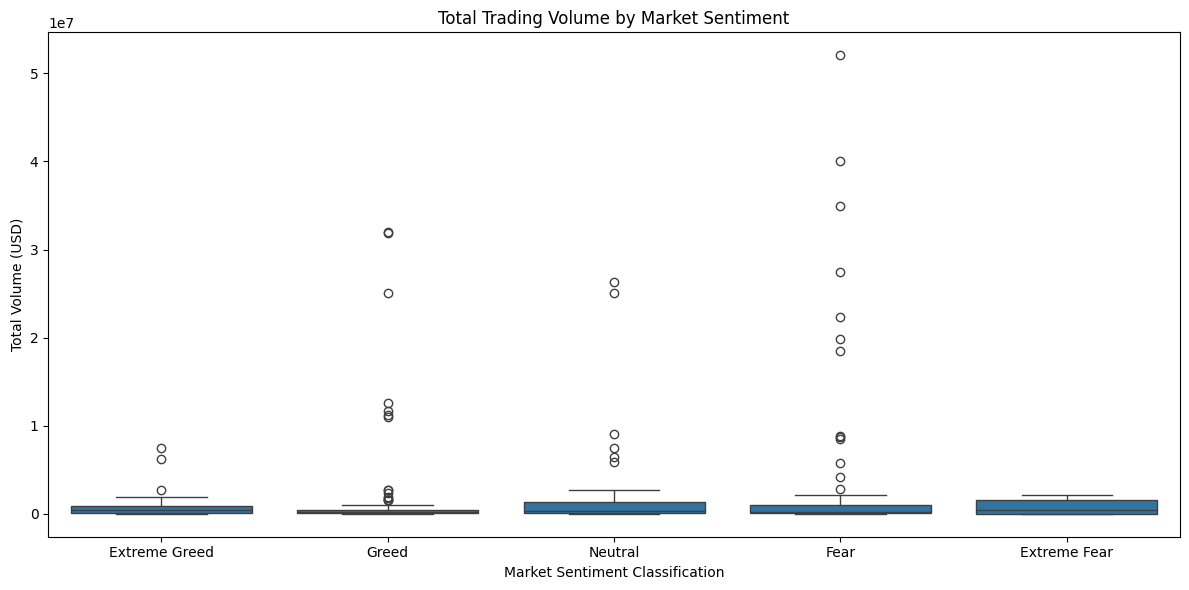

In [91]:
# Visualization of Total Volume by Sentiment Classification
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_data, x='classification', y='total_volume')
plt.title('Total Trading Volume by Market Sentiment')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Total Volume (USD)')
plt.tight_layout()
plt.show()

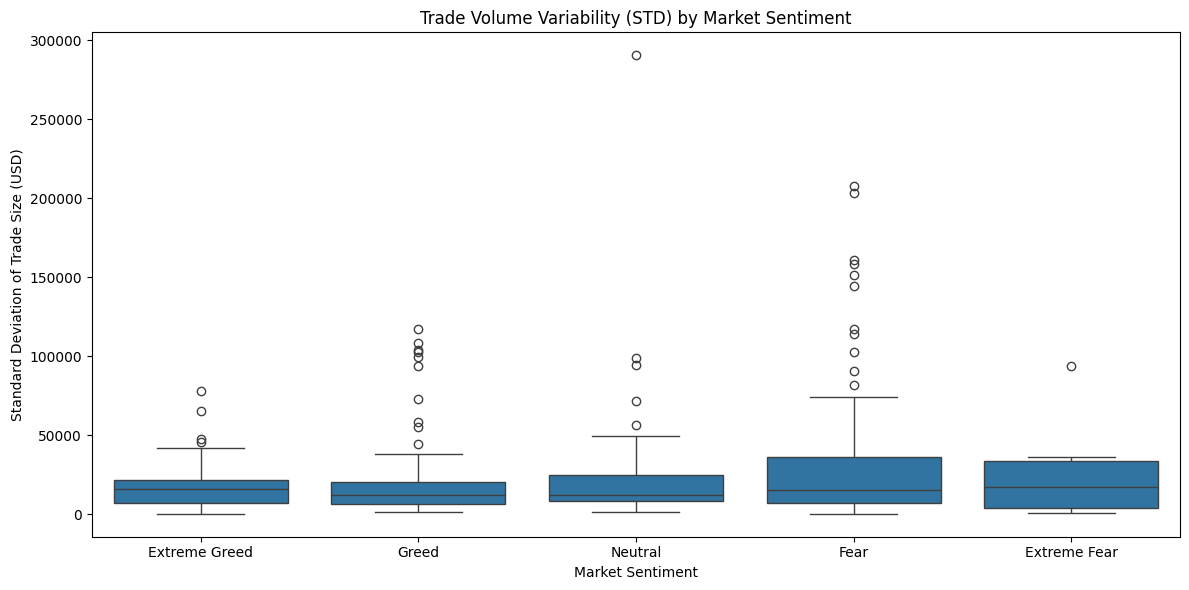

In [98]:
# Visualize risk metrics by market sentiment
plt.figure(figsize=(12,6))
sns.boxplot(data=risk_merged, x='classification', y='std_trade_volume')
plt.title('Trade Volume Variability (STD) by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Standard Deviation of Trade Size (USD)')
plt.tight_layout()
plt.show()

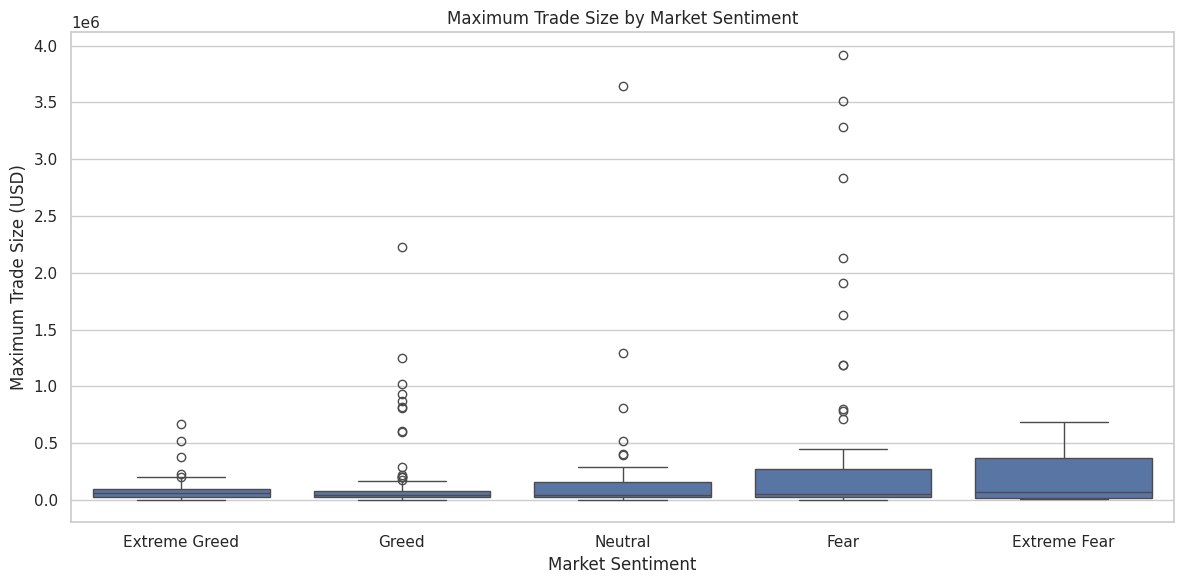

In [121]:
# Visualize Maximum Trade Size by Market Sentiment
plt.figure(figsize=(12,6))
sns.boxplot(data=risk_merged, x='classification', y='max_trade_volume')
plt.title('Maximum Trade Size by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Maximum Trade Size (USD)')
plt.tight_layout()
plt.show()

# Statistical test

In [93]:
# Split data into Fear and Greed groups (including Extreme Fear and Extreme Greed)
fear_mask = merged_data['classification'].str.contains('Fear')
greed_mask = merged_data['classification'].str.contains('Greed')

fear_pnl = merged_data.loc[fear_mask, 'avg_closedPnL']
greed_pnl = merged_data.loc[greed_mask, 'avg_closedPnL']

fear_vol = merged_data.loc[fear_mask, 'total_volume']
greed_vol = merged_data.loc[greed_mask, 'total_volume']

fear_trades = merged_data.loc[fear_mask, 'total_trades']
greed_trades = merged_data.loc[greed_mask, 'total_trades']

In [94]:
# Perform t-tests
def print_ttest_result(metric_name, fear_data, greed_data):
    t_stat, p_val = ttest_ind(fear_data, greed_data, nan_policy='omit')
    print(f"T-test for {metric_name} between Fear and Greed groups:")
    print(f" t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}\n")

print_ttest_result("Average Closed PnL", fear_pnl, greed_pnl)
print_ttest_result("Total Volume", fear_vol, greed_vol)
print_ttest_result("Total Trades", fear_trades, greed_trades)

T-test for Average Closed PnL between Fear and Greed groups:
 t-statistic = 1.168, p-value = 0.24390

T-test for Total Volume between Fear and Greed groups:
 t-statistic = 3.200, p-value = 0.00154

T-test for Total Trades between Fear and Greed groups:
 t-statistic = 3.428, p-value = 0.00070



# Correlation Calculation

In [100]:
# Convert sentiment 'value' to numeric
merged_data['value'] = pd.to_numeric(merged_data['value'], errors='coerce')

In [118]:
# Calculate correlations
corr_volume = merged_data['value'].corr(merged_data['total_volume'])
corr_avg_pnl = merged_data['value'].corr(merged_data['avg_closedPnL'])
corr_total_trades = merged_data['value'].corr(merged_data['total_trades'])

print(f"Correlation between Sentiment Value and Total Trading Volume: {corr_volume:.3f}")
print(f"Correlation between Sentiment Value and Average Closed PnL: {corr_avg_pnl:.3f}")
print(f"Correlation between Sentiment Value and Total Number of Trades: {corr_total_trades:.3f}")

Correlation between Sentiment Value and Total Trading Volume: -0.157
Correlation between Sentiment Value and Average Closed PnL: -0.116
Correlation between Sentiment Value and Total Number of Trades: -0.182


# Merged CSV Files

In [138]:
os.makedirs('csv_files', exist_ok=True)

# Save daily aggregated trader metrics
daily_trader_metrics.to_csv('csv_files/daily_trader_metrics.csv', index=False)

# Save merged dataset (aggregated trader data + sentiment)
merged_data.to_csv('csv_files/merged_trader_sentiment.csv', index=False)